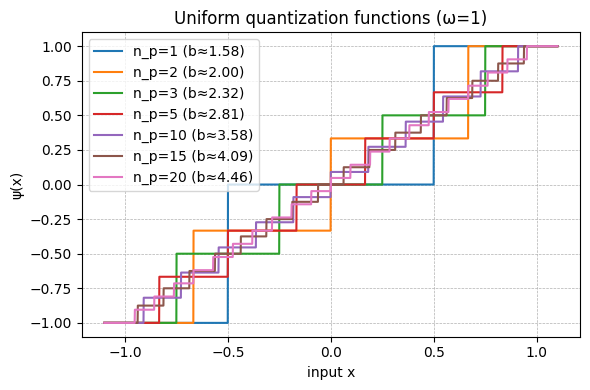

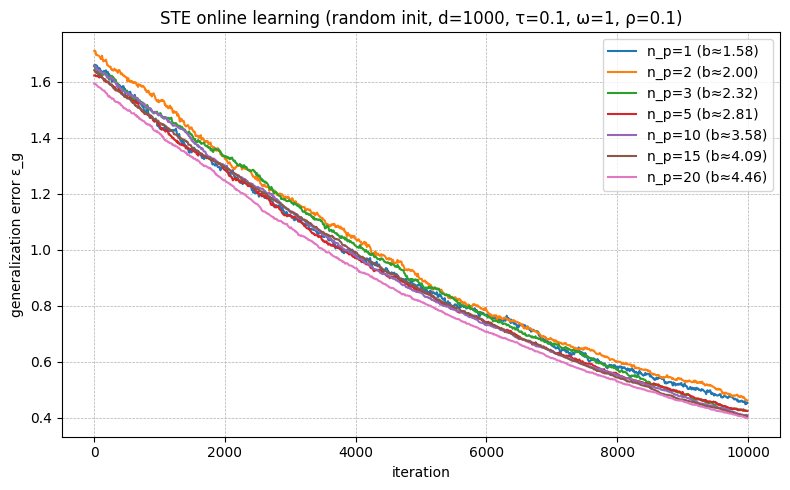

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# ===== updated full code with random initialization =====
def quantize(vec: np.ndarray, omega: float, n_p: int) -> np.ndarray:
    levels = n_p + 2
    step = 2 * omega / (levels - 1)
    clipped = np.clip(vec, -omega, omega)
    indices = np.round((clipped + omega) / step)
    return -omega + indices * step

def order_params_error(w_quant: np.ndarray, w0: np.ndarray, rho: float) -> float:
    d = w0.size
    m0 = 1.0  # (1/d)||w0||^2 = 1  (w0 = 1-vector)
    m_psi = (w_quant @ w0) / d
    q_psi = (w_quant @ w_quant) / d
    return m0 - 2 * m_psi + q_psi + rho

def run_experiment(
    d: int,
    tau: float,
    omega: float,
    rho: float,
    n_p_list: list,
    T: int = 10_000,
    record_every: int = 10,
    seed: int = 0,
):
    rng = np.random.default_rng(seed)
    w0_teacher = np.ones(d)
    results = {}
    for n_p in n_p_list:
        # --- random Gaussian initial weights ---
        w = rng.standard_normal(d)
        eps_hist, steps_hist = [], []
        for t in range(T):
            x = rng.standard_normal(d)
            noise = rng.standard_normal() * np.sqrt(rho)
            y = (w0_teacher @ x) / np.sqrt(d) + noise

            w_quant = quantize(w, omega, n_p)
            y_hat = (w_quant @ x) / np.sqrt(d)

            grad = - (y - y_hat) * x / np.sqrt(d)
            w -= tau * grad

            if t % record_every == 0:
                eps_hist.append(order_params_error(w_quant, w0_teacher, rho))
                steps_hist.append(t)

        results[n_p] = (np.array(steps_hist), np.array(eps_hist))
    return results

def plot_quant_funcs(omega: float, n_p_list: list):
    x_plot = np.linspace(-omega * 1.1, omega * 1.1, 2001)
    fig, ax = plt.subplots(figsize=(6, 4))
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for idx, n_p in enumerate(n_p_list):
        ax.plot(x_plot, quantize(x_plot, omega, n_p),
                color=colors[idx % len(colors)],
                label=f"n_p={n_p} (b≈{np.log2(n_p+2):.2f})")
    ax.set_xlabel("input x")
    ax.set_ylabel("ψ(x)")
    ax.set_title(f"Uniform quantization functions (ω={omega})")
    ax.grid(True, linestyle="--", linewidth=0.5)
    ax.legend()
    plt.tight_layout()
    plt.show()

def plot_epsilon(results: dict, omega: float, d: int, tau: float, rho: float):
    fig, ax = plt.subplots(figsize=(8, 5))
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for idx, (n_p, (steps, eps)) in enumerate(results.items()):
        ax.plot(steps, eps,
                color=colors[idx % len(colors)],
                label=f"n_p={n_p} (b≈{np.log2(n_p+2):.2f})")
    ax.set_xlabel("iteration")
    ax.set_ylabel("generalization error ε_g")
    # ax.set_yscale("log")
    ax.set_title(f"STE online learning (random init, d={d}, τ={tau}, ω={omega}, ρ={rho})")
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax.legend()
    plt.tight_layout()
    plt.show()

# ----- run experiment with ρ=0.001 -----
d = 1000
tau = 0.1
omega = 1
rho = 0.1
n_p_list = [1, 2, 3, 5, 10, 15, 20]
T = 10000
record_every = 10

plot_quant_funcs(omega, n_p_list)

results_random_init = run_experiment(
    d=d,
    tau=tau,
    omega=omega,
    rho=rho,
    n_p_list=n_p_list,
    T=T,
    record_every=record_every,
    seed=123
)

plot_epsilon(results_random_init, omega, d, tau, rho)


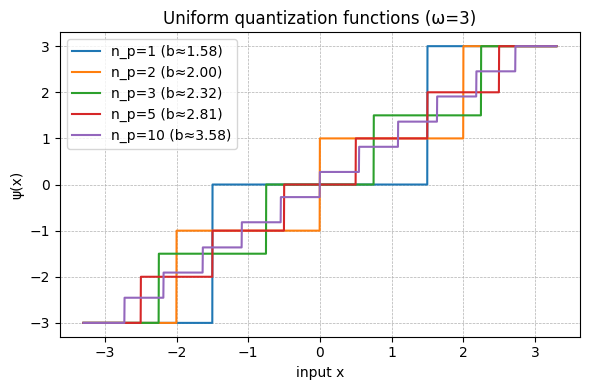

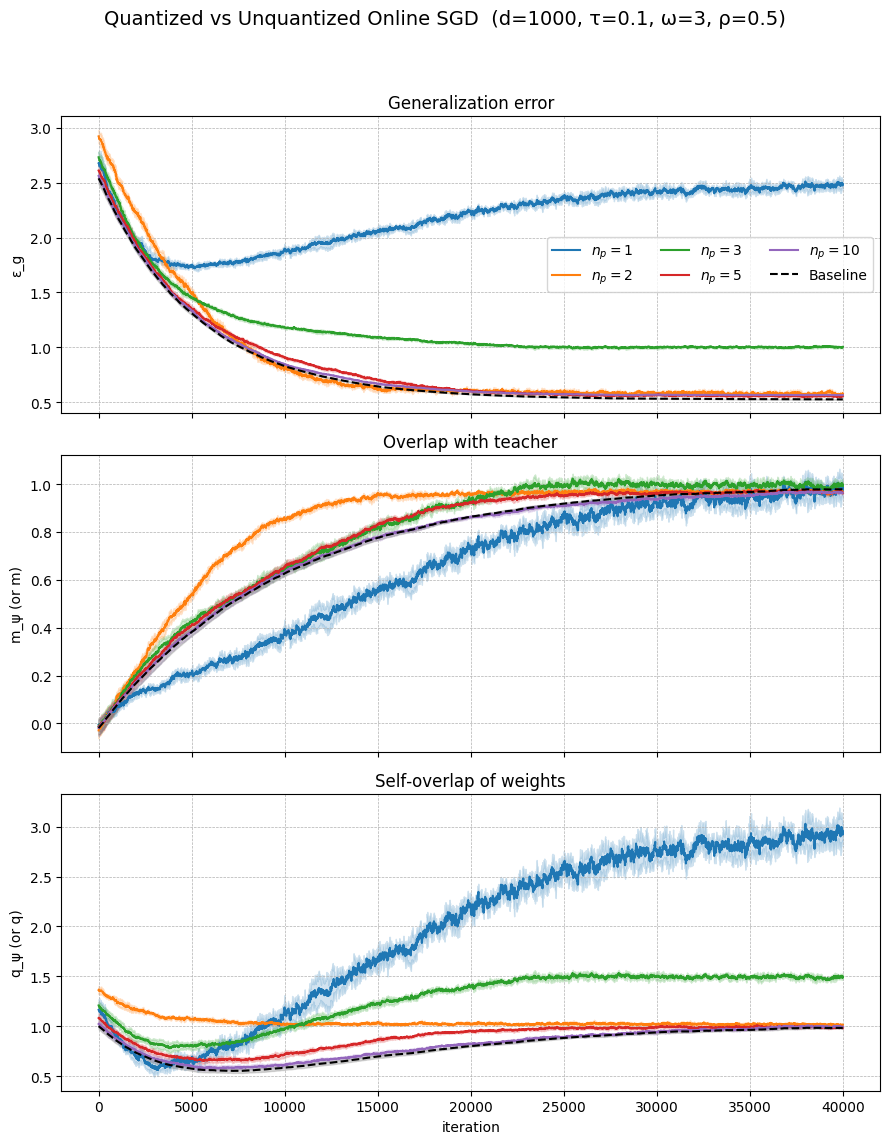

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------
# helper functions
# -------------------------------------------------
def quantize(vec, omega, n_p):
    """Uniform symmetric quantization with clipping to [-ω, ω]"""
    levels = n_p + 2
    step = 2 * omega / (levels - 1)
    clipped = np.clip(vec, -omega, omega)
    idx = np.round((clipped + omega) / step)
    return -omega + idx * step


def run_one(d, tau, omega, rho, n_p, T, record_every, rng, quantized=True):
    """Run a single online SGD (with or without STE) and return order‑parameter traces."""
    w0_teacher = np.ones(d)
    w = rng.standard_normal(d)

    steps, eps, m_hist, q_hist = [], [], [], []

    for t in range(T):
        x = rng.standard_normal(d)
        y = (w0_teacher @ x) / np.sqrt(d) + rng.standard_normal() * np.sqrt(rho)

        if quantized:
            w_eff = quantize(w, omega, n_p)
        else:
            w_eff = w                        # no quantization

        y_hat = (w_eff @ x) / np.sqrt(d)
        grad = - (y - y_hat) * x / np.sqrt(d)  # STE gradient coincides with true for no‑quant
        w -= tau * grad

        if t % record_every == 0:
            m = (w_eff @ w0_teacher) / d
            q = (w_eff @ w_eff) / d
            err = 1.0 - 2 * m + q + rho      # ε_g  (m0 = 1 for teacher of 1's)

            steps.append(t)
            eps.append(err)
            m_hist.append(m)
            q_hist.append(q)

    return np.array(steps), np.array(eps), np.array(m_hist), np.array(q_hist)


def run_multi_seeds(d, tau, omega, rho, n_p_list, seeds, T=10_000, record_every=10):
    """Run many seeds; return dict[n_p] = {'steps', 'mean', 'std', ...}"""
    results = {}

    for n_p in n_p_list:
        eps_all, m_all, q_all = [], [], []

        for seed in seeds:
            rng = np.random.default_rng(seed)
            steps, eps, m_hist, q_hist = run_one(
                d, tau, omega, rho, n_p, T, record_every, rng, quantized=True
            )
            eps_all.append(eps)
            m_all.append(m_hist)
            q_all.append(q_hist)

        eps_all = np.stack(eps_all)
        m_all = np.stack(m_all)
        q_all = np.stack(q_all)

        results[n_p] = {
            'steps': steps,
            'eps_mean': eps_all.mean(axis=0),
            'eps_std':  eps_all.std(axis=0),
            'm_mean':   m_all.mean(axis=0),
            'm_std':    m_all.std(axis=0),
            'q_mean':   q_all.mean(axis=0),
            'q_std':    q_all.std(axis=0),
        }
    return results


def run_baseline_seeds(d, tau, rho, seeds, T=10_000, record_every=10):
    """No quantization baseline"""
    eps_all, m_all, q_all = [], [], []

    for seed in seeds:
        rng = np.random.default_rng(seed)
        steps, eps, m_hist, q_hist = run_one(
            d, tau, omega=0, rho=rho, n_p=0, T=T,
            record_every=record_every, rng=rng, quantized=False
        )
        eps_all.append(eps)
        m_all.append(m_hist)
        q_all.append(q_hist)

    eps_all = np.stack(eps_all)
    m_all = np.stack(m_all)
    q_all = np.stack(q_all)

    return {
        'steps': steps,
        'eps_mean': eps_all.mean(axis=0),
        'eps_std':  eps_all.std(axis=0),
        'm_mean':   m_all.mean(axis=0),
        'm_std':    m_all.std(axis=0),
        'q_mean':   q_all.mean(axis=0),
        'q_std':    q_all.std(axis=0),
    }

# -------------------------------------------------
# experiment parameters
# -------------------------------------------------
d = 1000
tau = 0.1
omega = 3
rho = 0.5
n_p_list = [1, 2, 3, 5, 10]
T = 40000
record_every = 10
seeds = [0, 1, 2, 3, 4]     # five different initializations


plot_quant_funcs(omega, n_p_list)

# -------------------------------------------------
# run experiments
# -------------------------------------------------
quant_results = run_multi_seeds(d, tau, omega, rho, n_p_list, seeds, T, record_every)
baseline = run_baseline_seeds(d, tau, rho, seeds, T, record_every)

# -------------------------------------------------
# plotting
# -------------------------------------------------
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
fig, axes = plt.subplots(3, 1, figsize=(9, 12), sharex=True)

# --- ε_g ---
ax = axes[0]
for idx, n_p in enumerate(n_p_list):
    r = quant_results[n_p]
    ax.plot(r['steps'], r['eps_mean'], color=colors[idx % len(colors)],
            label=fr"$n_p=${n_p}")
    ax.fill_between(r['steps'],
                    r['eps_mean'] - r['eps_std'],
                    r['eps_mean'] + r['eps_std'],
                    color=colors[idx % len(colors)], alpha=0.2)
# baseline
ax.plot(baseline['steps'], baseline['eps_mean'], color='black', linestyle='--', label='Baseline')
ax.fill_between(baseline['steps'],
                baseline['eps_mean'] - baseline['eps_std'],
                baseline['eps_mean'] + baseline['eps_std'],
                color='gray', alpha=0.3)
ax.set_ylabel("ε_g")
# ax.set_yscale("log")
ax.set_title("Generalization error")
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.legend(ncol=3)

# --- m_ψ ---
ax = axes[1]
for idx, n_p in enumerate(n_p_list):
    r = quant_results[n_p]
    ax.plot(r['steps'], r['m_mean'], color=colors[idx % len(colors)])
    ax.fill_between(r['steps'],
                    r['m_mean'] - r['m_std'],
                    r['m_mean'] + r['m_std'],
                    color=colors[idx % len(colors)], alpha=0.2)
ax.plot(baseline['steps'], baseline['m_mean'], color='black', linestyle='--')
ax.fill_between(baseline['steps'],
                baseline['m_mean'] - baseline['m_std'],
                baseline['m_mean'] + baseline['m_std'],
                color='gray', alpha=0.3)
ax.set_ylabel("m_ψ (or m)")
ax.set_title("Overlap with teacher")
ax.grid(True, linestyle='--', linewidth=0.5)

# --- q_ψ ---
ax = axes[2]
for idx, n_p in enumerate(n_p_list):
    r = quant_results[n_p]
    ax.plot(r['steps'], r['q_mean'], color=colors[idx % len(colors)])
    ax.fill_between(r['steps'],
                    r['q_mean'] - r['q_std'],
                    r['q_mean'] + r['q_std'],
                    color=colors[idx % len(colors)], alpha=0.2)
ax.plot(baseline['steps'], baseline['q_mean'], color='black', linestyle='--')
ax.fill_between(baseline['steps'],
                baseline['q_mean'] - baseline['q_std'],
                baseline['q_mean'] + baseline['q_std'],
                color='gray', alpha=0.3)
ax.set_ylabel("q_ψ (or q)")
ax.set_xlabel("iteration")
ax.set_title("Self‑overlap of weights")
ax.grid(True, linestyle='--', linewidth=0.5)

plt.suptitle(f"Quantized vs Unquantized Online SGD  (d={d}, τ={tau}, ω={omega}, ρ={rho})",
            fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
